# 4. Robust Statistics and Non-Linear Methods

In this section, we will study different robust statistical techniques based on the data of three selected stocks (Apple AAPL, IBM and JP Morgan Chase JPM) as well as one index (Industrial Dow Jones DJI). We will use the following data from the period 16-03-2018 to 11-03-2019: open, close, high, low, adj. close.

## 4.1. Data Import and Exploratory Data Analysis

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import pearsonr, iqr
from datetime import datetime
from statsmodels.robust.scale import mad as mad_c
import copy
from sklearn.linear_model import LinearRegression, HuberRegressor

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# set the scaling factor to 1
def mad(a):
    return mad_c(a, c=1)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Read data
mydateparser = lambda x: datetime.strptime(x, "%Y-%m-%d")

AAPL = pd.read_csv("AAPL.csv", index_col=0, parse_dates=True, date_parser=mydateparser)
IBM = pd.read_csv("IBM.csv", index_col=0, parse_dates=True, date_parser=mydateparser)
JPM = pd.read_csv("JPM.csv", index_col=0, parse_dates=True, date_parser=mydateparser)
DJI = pd.read_csv("DJI.csv", index_col=0, parse_dates=True, date_parser=mydateparser)

stocks_data = {'AAPL': AAPL, 'IBM': IBM, 'JPM': JPM, 'DJI': DJI}

### 4.1.1 Descriptive statistics of stocks

For each of the stock and each column we generate key statistics to summarise the distribution of the data which are: mean, median, standard deviation, median absolute deviation (MAD), interquartile range (IQR), skewness (to measure the asymmetry) and kurtosis (measure for the tailness) that are presented in Table \ref{tab:stats}. We also add the one day returns as a new column to use later on.

We observe that the means and medians are close to each other within columns of a stock, whereas the standard deviation and median absolute deviation are more separated in terms of value. Additionally, we note that the median standard deviations are generally smaller than the standard deviations and that it is close to half of the IQR in most cases.

In [ ]:
stocks_stats = {}
stocks_stats_df = pd.DataFrame(columns=stocks_data['AAPL'].columns)

for stock in stocks_data:
    df = stocks_data[stock]
    stats = pd.DataFrame(columns=df.columns)

    stats.loc['mean'] = df.mean()
    stats.loc['median'] = df.median()
    stats.loc['stddev'] = df.std()
    stats.loc['MAD'] = mad(df)
    stats.loc['IQR'] = iqr(df, axis=0)
    stats.loc['skewness'] = df.skew()
    stats.loc['kurtosis'] = df.kurtosis()
    print(stock, pd.DataFrame.to_latex(round(stats,2)))
    stocks_stats[stock] = copy.deepcopy(stats)

AAPL \begin{tabular}{lrrrrrr}
\toprule
{} &    Open &    High &     Low &   Close &  Adj Close &       Volume \\
\midrule
mean     &  187.69 &  189.56 &  185.82 &  187.71 &     186.17 &  32704750.20 \\
median   &  186.29 &  187.40 &  184.94 &  186.12 &     184.35 &  29184000.00 \\
stddev   &   22.15 &   22.28 &   22.01 &   22.16 &      21.90 &  14179721.59 \\
MAD      &   15.89 &   15.61 &   15.92 &   15.94 &      15.48 &   7573900.00 \\
IQR      &   36.00 &   36.34 &   36.06 &   36.76 &      35.69 &  16311700.00 \\
skewness &    0.26 &    0.30 &    0.22 &    0.26 &       0.29 &         1.74 \\
kurtosis &   -0.91 &   -0.92 &   -0.92 &   -0.93 &      -0.93 &         4.35 \\
\bottomrule
\end{tabular}

IBM \begin{tabular}{lrrrrrr}
\toprule
{} &    Open &    High &     Low &   Close &  Adj Close &      Volume \\
\midrule
mean     &  138.45 &  139.49 &  137.33 &  138.36 &     134.90 &  5198937.45 \\
median   &  142.81 &  143.99 &  142.06 &  142.71 &     138.57 &  4237900.00 \\
stddev   &   

In [ ]:
for stock in stocks_data:
    stocks_data[stock]['Returns'] = stocks_data[stock]['Adj Close'].pct_change()

### 4.1.2 Pdf of adjusted close and returns

In Figure \ref{fig:4.1.2}, we plot the probability density functions of the adjusted 1 day close prices returns. As we previously discussed in section 1.1.3, returns tend to follow a Gaussian distribution when prices don't andn this can be observed in Figure \ref{fig:4.1.2}. 
When a distribution of a signal is not Gaussian, it may not be appropriate to represent that signal with its mean and standard deviation. In this case, we can use other statistics such as the median and median absolute deviation which would give use a more robust presentation of the signal of interest.

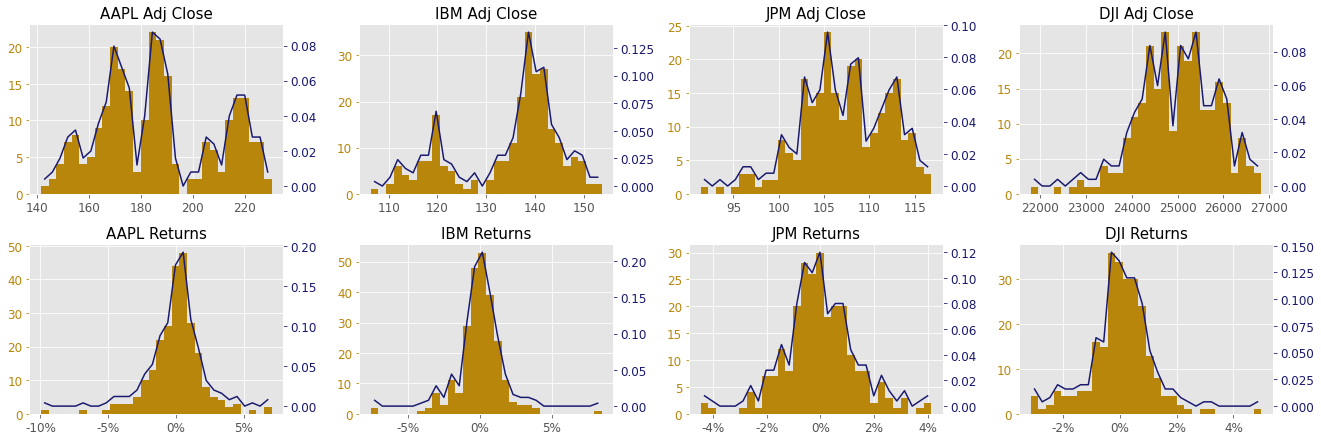

In [ ]:
fig, axes = plt.subplots(2,4, figsize=(18,6))
fig.tight_layout()
fig.subplots_adjust(hspace=0.3, wspace=0.3)


for i, stock in enumerate(stocks_data):
    adj_close = stocks_data[stock]['Adj Close']
    returns = stocks_data[stock]['Returns']
    
    # Plot adjusted close
    axes[0,i].set_title(stock+' Adj Close', fontsize=15)
    counts_and_vals = axes[0,i].hist(adj_close, bins=30, color='darkgoldenrod');
    
    axes[0,i].tick_params(axis='y', colors='darkgoldenrod', labelsize=12)
    axes[0,i].tick_params(axis='x', labelsize=12)


    x_vals = (counts_and_vals[1][1:] + counts_and_vals[1][0:-1]) / 2
    y_vals = counts_and_vals[0]/counts_and_vals[0].sum()
    
    twinax = axes[0,i].twinx()
    twinax.plot(x_vals, y_vals, color='midnightblue')
    twinax.tick_params(axis='y', colors='midnightblue', labelsize=12)
    twinax.grid(False)


    # Plot returns
    axes[1,i].set_title(stock+' Returns', fontsize=15)
    counts_and_vals = axes[1,i].hist(returns, bins=30, color='darkgoldenrod');

    axes[1,i].tick_params(axis='y', colors='darkgoldenrod', labelsize=12)
    axes[1,i].tick_params(axis='x', labelsize=12)
    vals = axes[1,i].get_xticks()
    axes[1,i].set_xticklabels(['{:,.0%}'.format(x) for x in vals]);

    
    x_vals = (counts_and_vals[1][1:] + counts_and_vals[1][0:-1]) / 2
    y_vals = counts_and_vals[0]/counts_and_vals[0].sum()
    
    twinax = axes[1,i].twinx()
    twinax.plot(x_vals, y_vals, color='midnightblue')
    twinax.tick_params(axis='y', colors='midnightblue', labelsize=12)
    twinax.grid(False)
    

fig.savefig('PDFs.eps', dpi=200, bbox_inches='tight')

### 4.1.3 Rolling mean and median statistics

In Figure \ref{fig:4.1.3_1},k we plot the adjusted close prices with its associated \textbf{rolling mean} (using a 5 days window) and the $\pm1.5\times$ \textbf{standard deviations} relative to the rolling mean for each of the asset. We repeat the same operation in Figure \ref{fig:4.1.3_2} using the \textbf{rolling median} and the $\pm1.5\times$ \textbf{standard deviations} associated to it.

The rolling mean (Figure \ref{fig:4.1.3_1}) and rolling median (Figure \ref{fig:4.1.3_2}) both represented in red are very similar to each other. However, we observe that the rolling deviations related to the median is much tighter and closer to the price action that the one of the mean. In Table \ref{tab:out} we compare the number of outlier points in each method and can confirm that indeed the median method contains more points outside that deviation area as it is more constrained. This suggests that mean estimators are more susceptible to price changes than the median estimators.

In [ ]:
outliers = pd.DataFrame(index=stocks_data.keys(), columns=['mean method', 'median method'])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

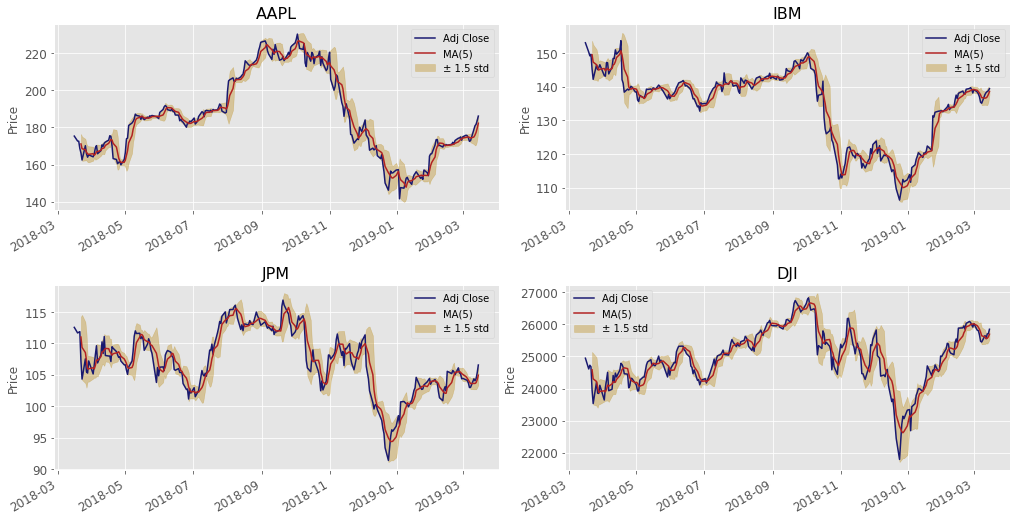

In [ ]:
# Rolling mean and std
window = 5

fig, axes = plt.subplots(2,2, figsize=(14,8))
fig.tight_layout()
fig.subplots_adjust(hspace=0.4, wspace=0.15)


for i, stock in enumerate(stocks_data):
    adj_close = stocks_data[stock]['Adj Close']

    rolling_mean = adj_close.rolling(window).mean()
    rolling_std  = adj_close.rolling(window).std()

    std_upper = rolling_mean + 1.5*rolling_std
    std_below = rolling_mean - 1.5*rolling_std

    if i == 0:
        ax = axes[0,0]
    elif i == 1:
        ax = axes[0,1]
    elif i == 2:
        ax = axes[1,0]
    elif i == 3:
        ax = axes[1,1]
    
    adj_close.plot(ax=ax, color='midnightblue', label='Adj Close', fontsize=12)
    rolling_mean.plot(ax=ax, color='firebrick', label='MA({})'.format(window))
    ax.fill_between(std_upper.index, std_upper, std_below, alpha=0.35, color='darkgoldenrod', label='\u00B1 1.5 std')
    
    ax.legend()
    ax.set_title(stock, fontsize=16)
    ax.set_ylabel('Price')
    ax.set_xlabel('')
    
    outliers['mean method'][stock] = (adj_close > std_upper).sum() + (adj_close < std_below).sum()
    

fig.savefig('Rolling_mean.eps', dpi=200, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

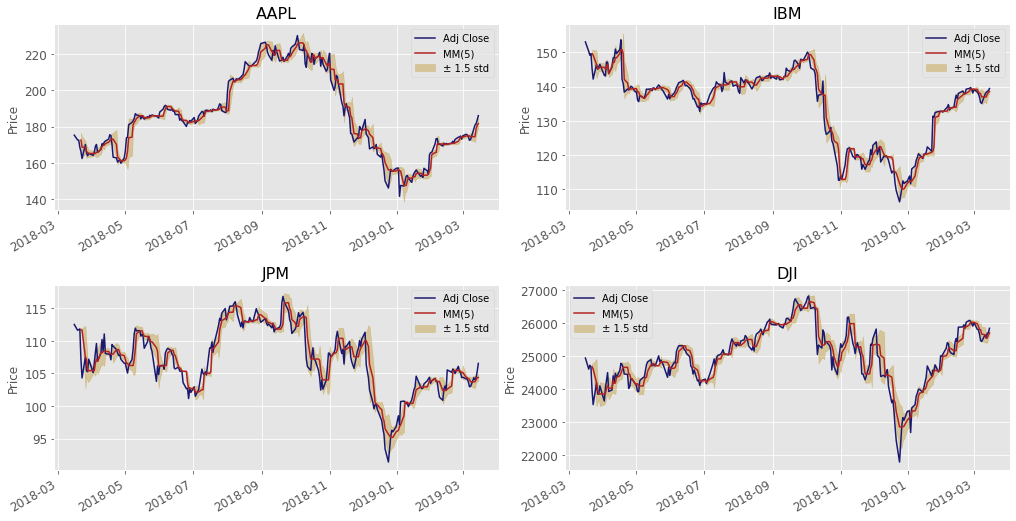

In [ ]:
# Rolling median and mad
window = 5

fig, axes = plt.subplots(2,2, figsize=(14,8))
fig.tight_layout()
fig.subplots_adjust(hspace=0.4, wspace=0.15)


for i, stock in enumerate(stocks_data):
    adj_close = stocks_data[stock]['Adj Close']

    rolling_median = adj_close.rolling(window).median()
    rolling_mad = adj_close.rolling(window).apply(mad, raw=True)

    mad_upper = rolling_median + 1.5*rolling_mad
    mad_below = rolling_median - 1.5*rolling_mad

    if i == 0:
        ax = axes[0,0]
    elif i == 1:
        ax = axes[0,1]
    elif i == 2:
        ax = axes[1,0]
    elif i == 3:
        ax = axes[1,1]
    
    adj_close.plot(ax=ax, color='midnightblue', label='Adj Close', fontsize=12)
    rolling_median.plot(ax=ax, color='firebrick', label='MM({})'.format(window))
    ax.fill_between(mad_upper.index, mad_upper, mad_below, alpha=0.35, color='darkgoldenrod', label='\u00B1 1.5 std')
    
    ax.legend()
    ax.set_title(stock, fontsize=16)
    ax.set_ylabel('Price')
    ax.set_xlabel('');
    
    outliers['median method'][stock] = (adj_close > mad_upper).sum() + (adj_close < mad_below).sum() 
    
    
    
fig.savefig('Rolling_median.eps', dpi=200, bbox_inches='tight')

In [ ]:
pd.DataFrame.to_latex(outliers)

'\\begin{tabular}{lll}\n\\toprule\n{} & mean method & median method \\\\\n\\midrule\nAAPL &          30 &           103 \\\\\nIBM  &          31 &            94 \\\\\nJPM  &          33 &           105 \\\\\nDJI  &          30 &            97 \\\\\n\\bottomrule\n\\end{tabular}\n'

### 4.1.4 Robustness to outliers

In this section, we introduce four outlier points for the adj. close with a value equal to $1.2 \times$ the maximum value of the column for the following four dates: 14-05-2018, 14-09-2018, 14-12-2018 and 14-01-2019. We want to observe the impact of those points on the graphs using the statistics of part 4.1.3.

We can observe from Figure \ref{fig:4.1.4_1} that the plot is largerly affected by outlier points with a big standard deviation while the one of the median in Figure \ref{fig:4.1.4_2} seems unafected in its rolling standard deviation. The latter seems more robust in sudden changes of price. We also observe that the rolling mean reacts more aburptly to these price changes that the rolling median. 

These observations suggest that the median estimators are more robust against noisy data that contains temporary outlier points, while mean estimators are more affected and susceptible to these changes.

In [ ]:
dates = ['2018-05-14', '2018-09-14', '2018-12-14', '2019-01-14']

adj_close_df = {}

for stock in stocks_data:
    adj_close_df[stock] = stocks_data[stock]['Adj Close']

adj_close_df = pd.DataFrame(adj_close_df)

for stock in adj_close_df.columns:
    max_val = adj_close_df[stock].max()
    for date in dates:
        adj_close_df[stock][date] = 1.2 * max_val

In [ ]:
outliers = pd.DataFrame(index=adj_close_df.columns, columns=['mean method', 'median method'])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

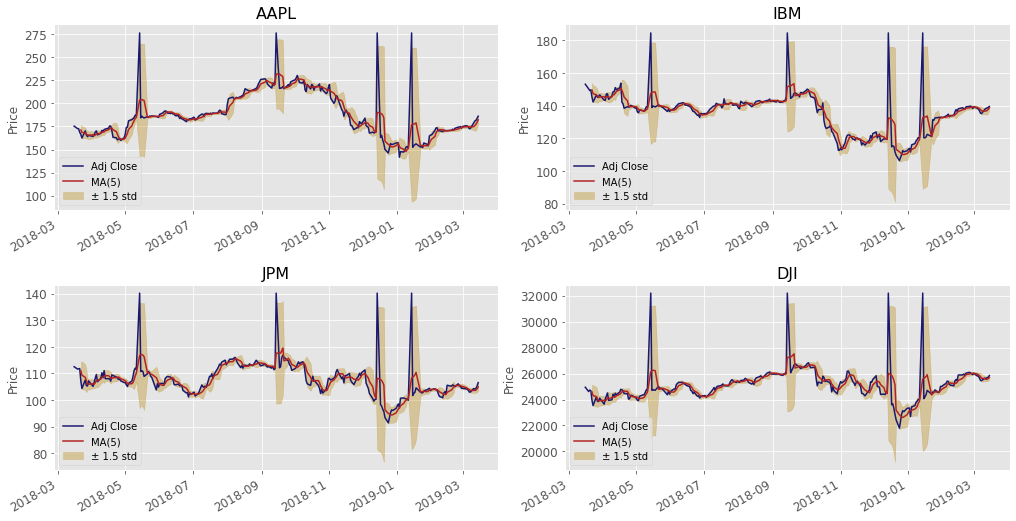

In [ ]:
# Rolling mean and std with added outliers
window = 5

fig, axes = plt.subplots(2,2, figsize=(14,8))
fig.tight_layout()
fig.subplots_adjust(hspace=0.4, wspace=0.15)


for i, stock in enumerate(adj_close_df.columns):
    adj_close = adj_close_df[stock]

    rolling_mean = adj_close.rolling(window).mean()
    rolling_std  = adj_close.rolling(window).std()

    std_upper = rolling_mean + 1.5*rolling_std
    std_below = rolling_mean - 1.5*rolling_std

    if i == 0:
        ax = axes[0,0]
    elif i == 1:
        ax = axes[0,1]
    elif i == 2:
        ax = axes[1,0]
    elif i == 3:
        ax = axes[1,1]
    
    adj_close.plot(ax=ax, color='midnightblue', label='Adj Close', fontsize=12)
    rolling_mean.plot(ax=ax, color='firebrick', label='MA({})'.format(window))
    ax.fill_between(std_upper.index, std_upper, std_below, alpha=0.35, color='darkgoldenrod', label='\u00B1 1.5 std')
    
    ax.legend()
    ax.set_title(stock, fontsize=16)
    ax.set_ylabel('Price')
    ax.set_xlabel('')
    
    outliers['mean method'][stock] = (adj_close > std_upper).sum() + (adj_close < std_below).sum()


fig.savefig('Rolling_mean_with_outliers.eps', dpi=200, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

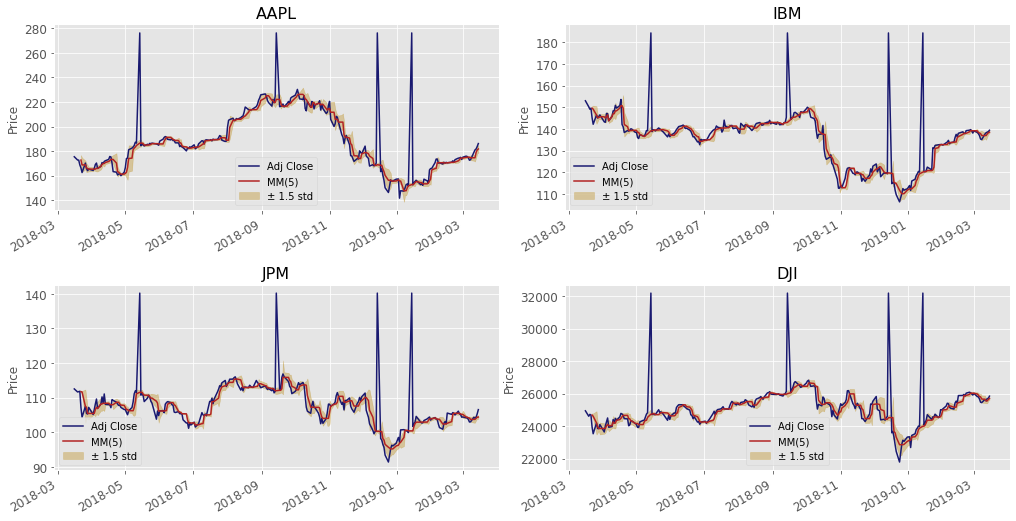

In [ ]:
# Rolling median and mad with added outliers
window = 5

fig, axes = plt.subplots(2,2, figsize=(14,8))
fig.tight_layout()
fig.subplots_adjust(hspace=0.4, wspace=0.15)


for i, stock in enumerate(adj_close_df.columns):
    adj_close = adj_close_df[stock]

    rolling_median = adj_close.rolling(window).median()
    rolling_mad = adj_close.rolling(window).apply(mad, raw=True)

    mad_upper = rolling_median + 1.5*rolling_mad
    mad_below = rolling_median - 1.5*rolling_mad

    if i == 0:
        ax = axes[0,0]
    elif i == 1:
        ax = axes[0,1]
    elif i == 2:
        ax = axes[1,0]
    elif i == 3:
        ax = axes[1,1]
    
    adj_close.plot(ax=ax, color='midnightblue', label='Adj Close', fontsize=12)
    rolling_median.plot(ax=ax, color='firebrick', label='MM({})'.format(window))
    ax.fill_between(mad_upper.index, mad_upper, mad_below, alpha=0.35, color='darkgoldenrod', label='\u00B1 1.5 std')
    
    ax.legend()
    ax.set_title(stock, fontsize=16)
    ax.set_ylabel('Price')
    ax.set_xlabel('');
    
    outliers['median method'][stock] = (adj_close > mad_upper).sum() + (adj_close < mad_below).sum() 
    

fig.savefig('Rolling_median_with_outliers.eps', dpi=200, bbox_inches='tight')

In [ ]:
pd.DataFrame.to_latex(outliers)

'\\begin{tabular}{lll}\n\\toprule\n{} & mean method & median method \\\\\n\\midrule\nAAPL &          32 &           102 \\\\\nIBM  &          31 &            93 \\\\\nJPM  &          33 &           101 \\\\\nDJI  &          29 &            96 \\\\\n\\bottomrule\n\\end{tabular}\n'

### 4.1.5 Box plots of prices

In order to better visualise distribution, dispersion and the key statistics of the data we can use another tool called box plot. We use it to graphically visualise the dispersion of our adj. close prices in Figure \ref{fig:4.1.5}. 

The blue line at the center of the box denotes the median of the data. The rectangilar box represents the interquartile range (from Q1 where 25\% of the data can be found to Q3 where 75\% of the data can be found) while the whiskers extend to represent the total range of the price data. From these are excluded the outliers which are represented as points and are defined to be outisde of the $1.5\times$ the IQR.

Overall, we see that the adj. close price data tends to be skewed with asymmetric quartiles and multiple outlier points. This confirm that the classic Gaussian models are unfit to describe price distributions.

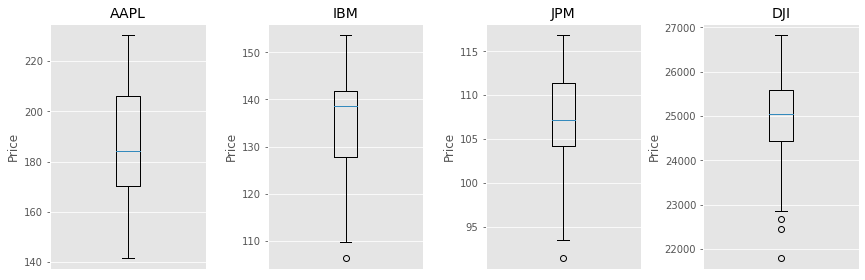

In [ ]:
fig, axes = plt.subplots(1,4, figsize=(12,4))
fig.tight_layout()
fig.subplots_adjust(hspace=0.2, wspace=0.4)


for i, stock in enumerate(stocks_data):
    adj_close = stocks_data[stock]['Adj Close']

    ax = axes[i]
    
    ax.boxplot(adj_close)
    
    ax.set_title(stock, fontsize=14)
    ax.set_ylabel('Price')
    ax.set_xticks([])
    

fig.savefig('Box_plots.eps', dpi=200, bbox_inches='tight')

## 4.2 Robust Estimators

In this section, we are going to implement, analyser and assess the following estimators:
*   Robust location estimator: median.
*   Robust scale estimator: IQR (interquartile range) and MAD (median absolute deviation)





### 4.2.1 Python Implementation

We first start by creating Python functions for the estimators:

In [ ]:
def Custom_Median (input):
    tmp = input.sort_values() # sorting
    median = tmp[round(len(tmp)/2)] # find middle values
    return median
    
def Custom_IQR (input):
    tmp = input.sort_values() # sorting
    q1 = tmp[round(len(tmp)/4)] # 25th percentile value
    q3 = tmp[round(len(tmp)/4*3)] # 75th percentile value
    iqr = q3-q1
    return iqr
    
def Custom_MAD (input):
    median = Custom_Median (input)
    deviations = abs(input - median)
    mad = Custom_Median(deviations) # compute the median of deviations
    return mad

The logic for each of the functions is the following:

* Median: we first sort the input series and take the middle value as the median of that series. We round up the index to cover both cases when the length of the input is odd and even.
* IQR: we sort the input series and find the 25th and 75th percentile values (corresponding to the the values where 25\% and 75\% of the data can be found respectively). The interquartile range is the absolute difference between these two values.
*  MAD: in order to find the median absolute deviation, we first find the median value. We then create a new series called deviations which is calculated from the absolute difference between the median and each element of the original input series. The MAD is the median of the newly created series deviations


### 4.2.2 Complexity Analysis

We will now study the computational complexity of the estimators we discussed:

* Median: we first perform a sorting operation which takes $\mathcal{O}(nlog(n))$. Then we find the middle value of the sorted series, which is a $\mathcal{O}(1)$ operation. Hence, the overall complexity of the median estimator is $\mathcal{O}(nlog(n))$.
* IQR: sorting the series takes a complexity of $\mathcal{O}(nlog(n))$. We then find two individual value in the 25th and 75th percentile value and perform a subtraction which are all $\mathcal{O}(1)$ operations. The overall complexity of the IQR estimator is $\mathcal{O}(nlog(n))$.
* MAD: computing the median of a series takes a $\mathcal{O}(nlog(n))$ complexity as seen above. From there, we can compute our new deviations series at a $\mathcal{O}(n)$ complexity. Computing the median of that series is again $\mathcal{O}(nlog(n))$ complexity. The overall complexity of the MAD 

We can note that the computational complexities of these estimators are much higher than those of more classic estimators such as the mean or the standard deviation which only take $\mathcal{O}(n)$.

### 4.2.3 Breakdown Points

A robust estimator should not be affected too much by large deviations from the model. In order to define the robustness of an estimator, we use its breakdown point which is the maximum fraction of outliers that an estimator can tolerate and it has a value between 0 and 0.5. The breakdown point is the percentage of data (expressed in decimal terms) that can be contaminated without deteriorating the estimators results. The higher the breakdown point, the more robust our estimator is. We observe the results for our estimators and the more traditional ones.

The median has a brekadown point of 0.5 which means it is a very robust estimator against outliers, which we had confirm in section 4.1. Since the median is the middle value in the set, even if half of the dataset was contaminated it would still be able to estimate correctly a valid point within the dataset. This contrasts with the mean which has a brekadown point of 0 as it is an average and by definition very susceptible to outliers as even one extreme value can falsify the estimation.

The median absolute deviation (MAD) also has a brekadown point of 0.5. The argument is similar to the one of the median as even if half of the dataset had extreme values, the median would still give a correct estimation and half of the deviations series would still stand correct and the median of that series would stand intact too. Once again, this contrasts with the standard deviation which gets affected by a single outlier.

Finally, the interquartile range (IQR) has a brekadown point of 0.25. As it estimates the 25th and 75th percentiles (equivalent to splitting the data in half and finding the median of each half series) then it can allow a quarter of the data to be contaminated (half for either series) before breaking down.

Overall, we note a trade-off between the robustness to outliers and the computational complexity in our estimators.

## 4.3 Robust and OLS Regression

### 4.3.1 OLS regression

In this section, we have regressed each stock's 1-day returns against the 1-day returns of the DJI index using the Ordinary Least Squares (OLS) regression. We can define this regression as:

\begin{equation}
\mathbf{r}_{asset} = \mathbf{Xb} + \mathbf{e}
\end{equation}

which can be rewritten:

\begin{equation}
\mathbf{r}_{asset} = \begin{bmatrix} \mathbf{1} & \mathbf{r}_{DJI} \end{bmatrix} \begin{bmatrix} \alpha \\ \beta \end{bmatrix} + \mathbf{e} \end{equation}

where $\mathbf{r}_{asset}$ is the vector representing the daily return of our considered asset (stock), $\mathbf{r}_{DJI}$ is the vector represent the daily returns of the Dow Jones, $\alpha$ and $\beta$ are the regression parameters and finally $\mathbf{e}$ is the error vector. 

The OLS method consists in minimising the squared error given by $\|\mathbf{e}\|^2 = \|\mathbf{r}_{asset} - \mathbf{Xb}\|^2$. The optimal solution is the one that minimises the loss function and is given by $\mathbf{\hat{b}} = (\mathbf{X^TX})^{-1}\mathbf{X^Tr}_{asset}$. The regression parameters obtained for each stock are given in  Table \ref{tab:ols} and the predictions of the regressor are given in Figure \ref{fig:ols} alongside the true value of the returns.

In [ ]:
for stock in stocks_data:
    stocks_data[stock]['Return'] = stocks_data[stock]['Adj Close'].pct_change()

returns = pd.DataFrame()
for stock in stocks_data:
    returns[stock] = stocks_data[stock]['Return']
returns.dropna(inplace=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


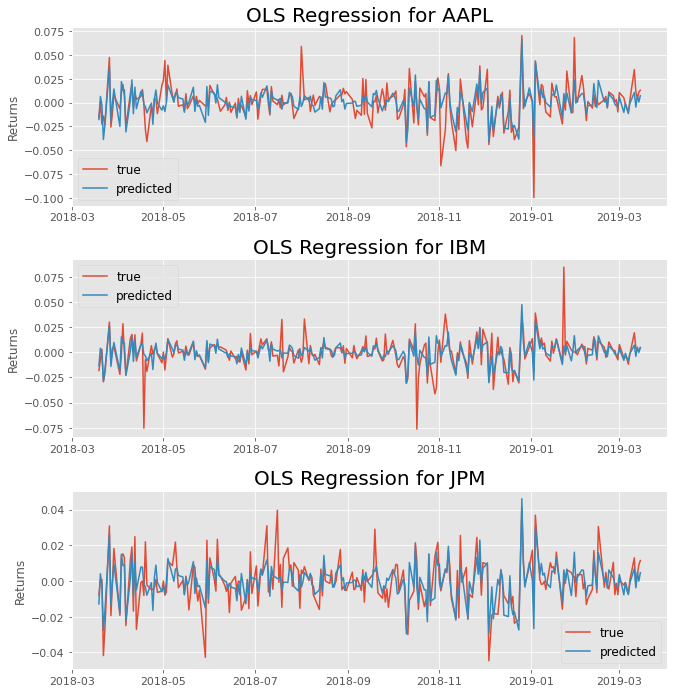

In [ ]:
# OLS regression
fig, axes = plt.subplots(3,1, figsize=(9,9.5))
fig.tight_layout()
fig.subplots_adjust(hspace=0.3)

OLS_coefs = pd.DataFrame(columns=returns.columns, index=['alpha', 'beta'])
r_DJI = returns['DJI'].values.reshape(-1,1)

for i, stock in enumerate(returns.columns):
    r_stock = returns[stock].values.reshape(-1,1)
    reg = LinearRegression().fit(r_DJI, r_stock)
    
    OLS_coefs[stock]['alpha'] = float(reg.intercept_)
    OLS_coefs[stock]['beta']  = float(reg.coef_)
    
    
    if stock != 'DJI':
        ax = axes[i]
        OLS_pred = reg.predict(r_DJI)
        
        ax.plot(returns[stock], label='true')
        ax.plot(returns[stock].index, OLS_pred, label='predicted')
        ax.set_title("OLS Regression for "+stock, fontsize=20)
        ax.set_ylabel('Returns')
        ax.tick_params(labelsize=11)
        ax.legend(fontsize=12)
    
    
fig.savefig('OLS_Regression.eps', dpi=200, bbox_inches='tight')

In [ ]:
OLS_coefs
# print(OLS_coefs.to_latex(float_format='%.2f'))

,AAPL,IBM,JPM,DJI
alpha,0.000165,-0.000441,-0.000316,0.0
beta,1.32558,0.960092,0.931408,1.0


### 4.3.2 Robust regression (Huber regression)

The Hubert regression is similar to the OLS regression except for the loss function to be minimise. This loss function $J$ is givewn by:

\begin{equation}
  J(y, \hat{y}) = 
  \begin{cases}
      (y-\hat{y})^2, & \text{if } \frac{|y-\hat{y}|}{\sigma} \leq \epsilon \\
      |y-\hat{y}|, & \text{otherwise}
  \end{cases}
\end{equation}

The Huber regressor aims to minimise the squared loss for the samples where $\frac{|y-\hat{y}|}{\sigma} \leq \epsilon$ and the absolute error otherwise. This means that, contrarely to the OLS regression, the loss function is not heavily impacted by the outliers while still not ignoring its effects. The parameter $\sigma$ is used to be able to normalise the fraction in case $y$ get scaled up or down, then $\epsilon$ does not need to be scaled too and can be used to control the error allowed to consider a point to be an outlier. 

The regression coeffcients obtained with the Huber regression are shown in Table \ref{tab:huber} with the predictions of the regressor shown in Figure \ref{fig:huber} alonside the true values of the returns. 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


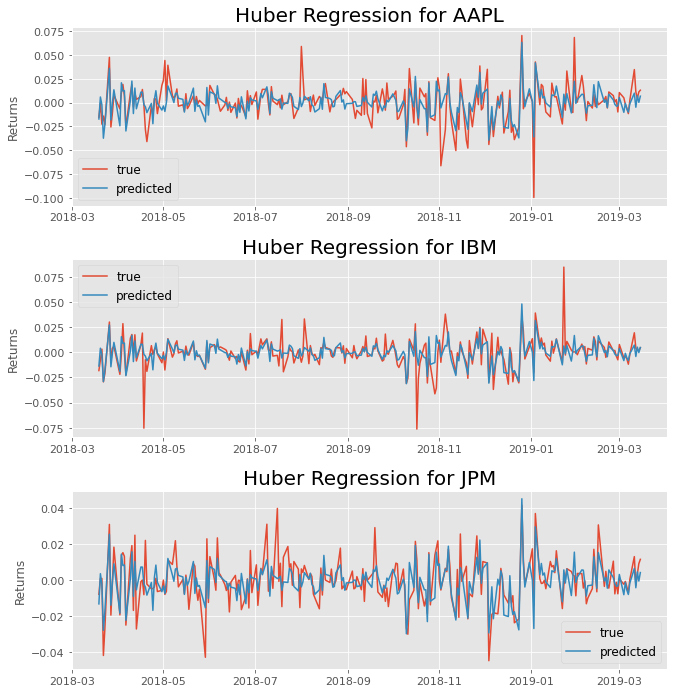

In [ ]:
# Huber regression
fig, axes = plt.subplots(3,1, figsize=(9,9.5))
fig.tight_layout()
fig.subplots_adjust(hspace=0.3)

huber_coefs = pd.DataFrame(columns=returns.columns, index=['alpha', 'beta'])
r_DJI = returns['DJI'].values.reshape(-1,1)

for i, stock in enumerate(returns.columns):
    r_stock = returns[stock].values
    huber = HuberRegressor().fit(r_DJI, r_stock)
    
    huber_coefs[stock]['alpha'] = float(huber.intercept_)
    huber_coefs[stock]['beta']  = float(huber.coef_)
    
    if stock != 'DJI':
        ax = axes[i]
        Huber_pred = huber.predict(r_DJI)
        
        ax.plot(returns[stock], label='true')
        ax.plot(returns[stock].index, Huber_pred, label='predicted')
        ax.set_title("Huber Regression for "+stock, fontsize=20)
        ax.set_ylabel('Returns')
        ax.tick_params(labelsize=11)
        ax.legend(fontsize=12)
    

fig.savefig('Huber_Regression.eps', dpi=200, bbox_inches='tight')

In [ ]:
huber_coefs

,AAPL,IBM,JPM,DJI
alpha,-0.00013,-0.000509,-0.000801,0.0
beta,1.270212,0.973562,0.919662,1.0


### 4.3.3 Huber vs. OLS regression

In [ ]:
r_with_outliers = copy.deepcopy(returns)
dates = ['2018-05-14', '2018-09-14', '2018-12-14', '2019-01-14']

for stock in r_with_outliers.columns:
    if stock == 'DJI':
        continue
    max_val = r_with_outliers[stock].max()
    for date in dates:
        r_with_outliers[stock][date] = 1.2 * max_val

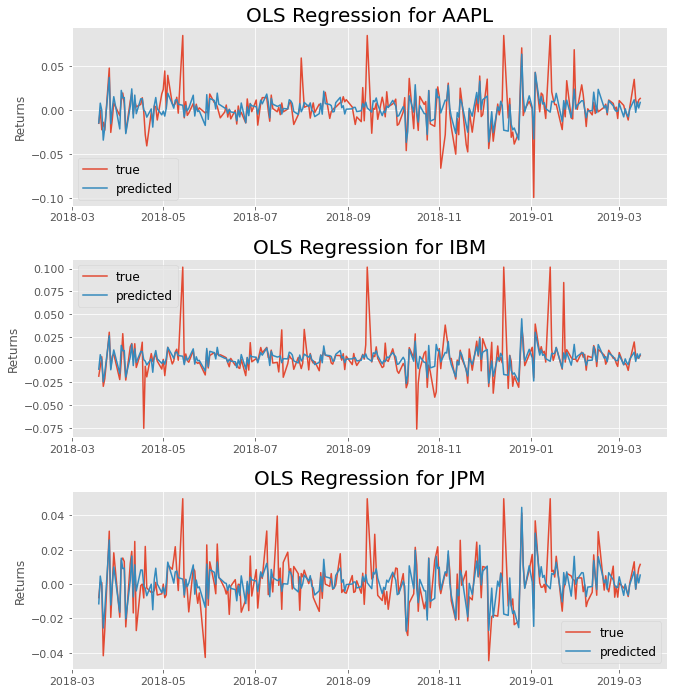

In [ ]:
# OLS regression
fig, axes = plt.subplots(3,1, figsize=(9,9.5))
fig.tight_layout()
fig.subplots_adjust(hspace=0.3)

returns = r_with_outliers # change returns to the version with outliers
OLS_coefs_outliers = pd.DataFrame(columns=returns.columns, index=['alpha', 'beta'])
r_DJI = returns['DJI'].values.reshape(-1,1)

for i, stock in enumerate(returns.columns):
    r_stock = returns[stock].values.reshape(-1,1)
    reg = LinearRegression().fit(r_DJI, r_stock)
    
    OLS_coefs_outliers[stock]['alpha'] = float(reg.intercept_)
    OLS_coefs_outliers[stock]['beta']  = float(reg.coef_)
    
    
    if stock != 'DJI':
        ax = axes[i]
        OLS_pred_outliers = reg.predict(r_DJI)
        
        ax.plot(returns[stock], label='true')
        ax.plot(returns[stock].index, OLS_pred_outliers, label='predicted')
        ax.set_title("OLS Regression for "+stock, fontsize=20)
        ax.set_ylabel('Returns')
        ax.tick_params(labelsize=11)
        ax.legend(fontsize=12)
    

In [ ]:
OLS_coefs_outliers

,AAPL,IBM,JPM,DJI
alpha,0.001778,0.001276,0.000479,0.0
beta,1.233421,0.87377,0.887547,1.0


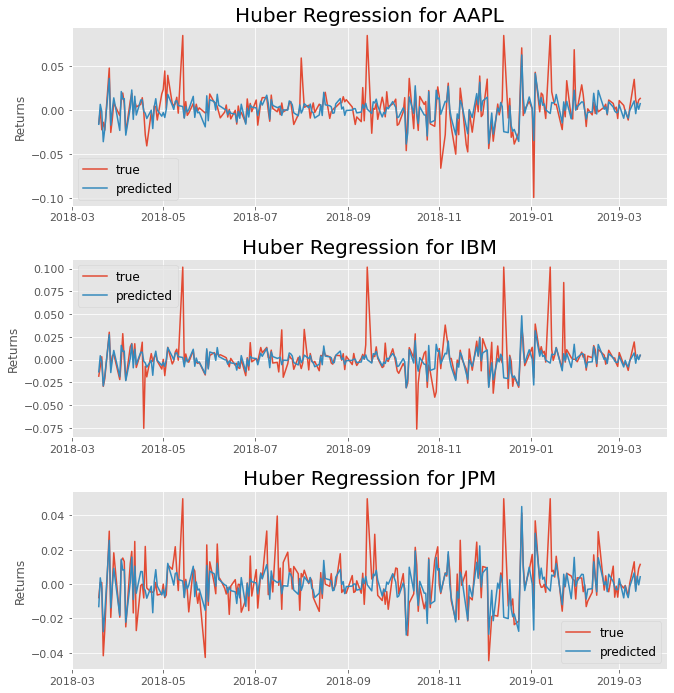

In [ ]:
# Huber regression
fig, axes = plt.subplots(3,1, figsize=(9,9.5))
fig.tight_layout()
fig.subplots_adjust(hspace=0.3)

returns = r_with_outliers # change returns to the version with outliers
huber_coefs_outliers = pd.DataFrame(columns=returns.columns, index=['alpha', 'beta'])
r_DJI = returns['DJI'].values.reshape(-1,1)

for i, stock in enumerate(returns.columns):
    r_stock = returns[stock].values
    huber = HuberRegressor().fit(r_DJI, r_stock)
    
    huber_coefs_outliers[stock]['alpha'] = float(huber.intercept_)
    huber_coefs_outliers[stock]['beta']  = float(huber.coef_)
    
    if stock != 'DJI':
        ax = axes[i]
        Huber_pred_outliers = huber.predict(r_DJI)
        
        ax.plot(returns[stock], label='true')
        ax.plot(returns[stock].index, Huber_pred_outliers, label='predicted')
        ax.set_title("Huber Regression for "+stock, fontsize=20)
        ax.set_ylabel('Returns')
        ax.tick_params(labelsize=11)
        ax.legend(fontsize=12)
    

In [ ]:
huber_coefs_outliers

,AAPL,IBM,JPM,DJI
alpha,0.000324,-0.000342,-0.000704,0.0
beta,1.244872,0.972195,0.920989,1.0


The coefficients obtained using the different regression methods have shown similarity in the results and so did the predictions when using both regressors. To be able to further test and compare the robustness of the two regressors, we introduce four outlier points at certain dates with values equivalent to $1.2 \times$ the maximum value of the series (similar to what we did in section 4.1.4). The obtained coefficients using both methods with the contaminated data are given in Table \ref{tab:olsout} and Table \ref{tab:hubberout}. The predictions of both regressors with the outliers are shown in Figure \ref{fig:outreg}.

In [ ]:
OLS_coefs

,AAPL,IBM,JPM,DJI
alpha,0.000165,-0.000441,-0.000316,0.0
beta,1.32558,0.960092,0.931408,1.0


In [ ]:
OLS_coefs_outliers

,AAPL,IBM,JPM,DJI
alpha,0.001778,0.001276,0.000479,0.0
beta,1.233421,0.87377,0.887547,1.0


In [ ]:
huber_coefs

,AAPL,IBM,JPM,DJI
alpha,-0.00013,-0.000509,-0.000801,0.0
beta,1.270212,0.973562,0.919662,1.0


In [ ]:
huber_coefs_outliers

,AAPL,IBM,JPM,DJI
alpha,0.000324,-0.000342,-0.000704,0.0
beta,1.244872,0.972195,0.920989,1.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


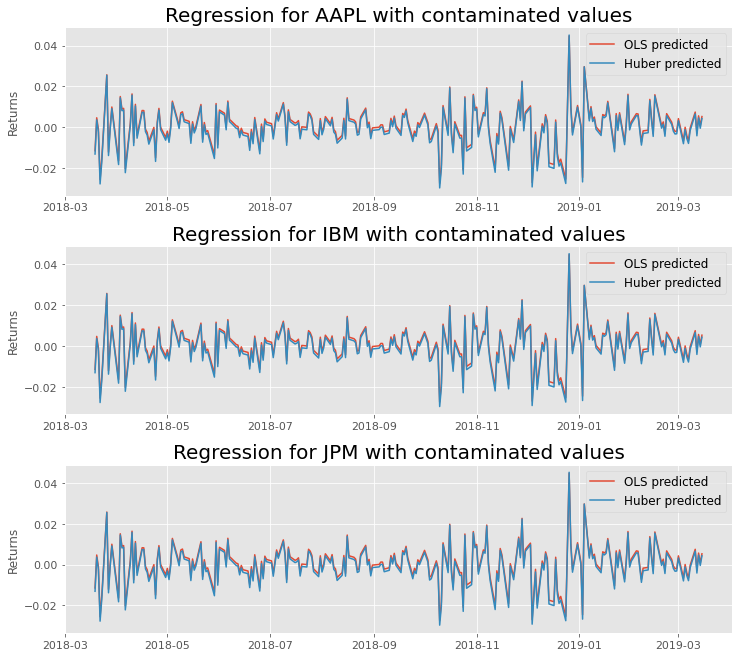

In [ ]:
# # OLS and Huber together with outliers
fig, axes = plt.subplots(3,1, figsize=(10,9))
fig.tight_layout()
fig.subplots_adjust(hspace=0.3)


for i, stock in enumerate(returns.columns):
    if stock != 'DJI':
        ax = axes[i]
        
#         ax.plot(returns[stock], label='true')
        ax.plot(returns[stock].index, OLS_pred_outliers, label='OLS predicted')
        ax.plot(returns[stock].index, Huber_pred_outliers, label='Huber predicted')
        ax.set_title("Regression for "+stock+" with contaminated values", fontsize=20)
        ax.set_ylabel('Returns')
        ax.tick_params(labelsize=11)
        ax.legend(fontsize=12)
    

fig.savefig('Both_Regressions_Together.eps', dpi=200, bbox_inches='tight')

We observe from Figure \ref{fig:outreg} that the predictions of both regressors with the outlier points are very similar. Since we only added 4 points, this small impact in performance is to be expected. However, if we look at Table \ref{coeffreg} and the changes of the coefficients when adding the outlier points, we observe that the Huber regression displays a more robust behaviour. Adding these four outlier points has a significant impact on the coeffcients of the OLS regressor while the ones of the Huber regressor stay almost intact. 

As mentionned in section 4.3.2, since the Huber regression limits the impact of very large errors in the estimation, it is more robust to outliers than the OLS regression. This has been demonstrated in this section as well.

## 4.4 Robust Trading Strategies

The Moving Average Crossover is a simple trading strategy that consists of the following rules:
\begin{itemize}
  \item Buy $X$ shares of a stock when its 20-day MA > 50-day MA
  \item Sell $X$ shares of the stock when its 20-day MA < 50-day MA
\end{itemize}

In this section, we will implement the simple and robust variation of the Moving Average Crossover Strategy.

In [ ]:
# adjusted closes
adj_closes = pd.DataFrame(columns = stocks_data.keys())
for stock in adj_closes.columns:
    adj_closes[stock] = stocks_data[stock]['Adj Close']
    
# corrupted adjusted closes
corrupted_adj_closes = copy.deepcopy(adj_closes)
for stock in corrupted_adj_closes.columns:
    adj_close = corrupted_adj_closes[stock]
    max_val = adj_close.max()
    min_val = adj_close.min()
    for i in range(0,250, 25):
        adj_close.iloc[i] = max_val * 1.2
    for i in range(15,250, 25):
        adj_close.iloc[i] = min_val * 0.8

In [ ]:
def get_decisions(signs):
    decision = {'start': signs.index[0], 'end': None, 'val': signs[0]}
    decisions = [decision]
    for t in signs.index:
        if decisions[-1]['end'] != None:
            decision = {'start': next_start, 'end': None, 'val': signs[t]}
            decisions.append(decision)

        val = signs[t]
        if decisions[-1]['val'] == val:
            continue
        else:
            decisions[-1]['end'] = t
            next_start = t

    decisions[-1]['end'] = signs.index[-1]

    return decisions

### 4.4.1 Simple Moving Average Crossover

For each stock, we plot the adj. close as well as the 20-day and 50-day \textbf{rolling mean} moving averages on the left plot of Figure \ref{4.4.1} as well as the buy (blue) and sell (red) regions which are highlighted following the crossover strategy. The performance of the strategy over time in terms of cumulative returns is also provided for each of the stock. We then repeat the same procedure but this time we include corrupted adj. close prices and we plot the corresponding results on the right plot of Figure \ref{4.4.1}. Table \ref{tab:4.4.1} displays the percentage of overlap between the two methods in order to quantify the robustness of the crossover strategy in the presence of outlier points.

Region overlap AAPL:	89.6%


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

Region overlap IBM:	86.1%


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

Region overlap JPM:	84.2%


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

Region overlap DJI:	85.1%


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

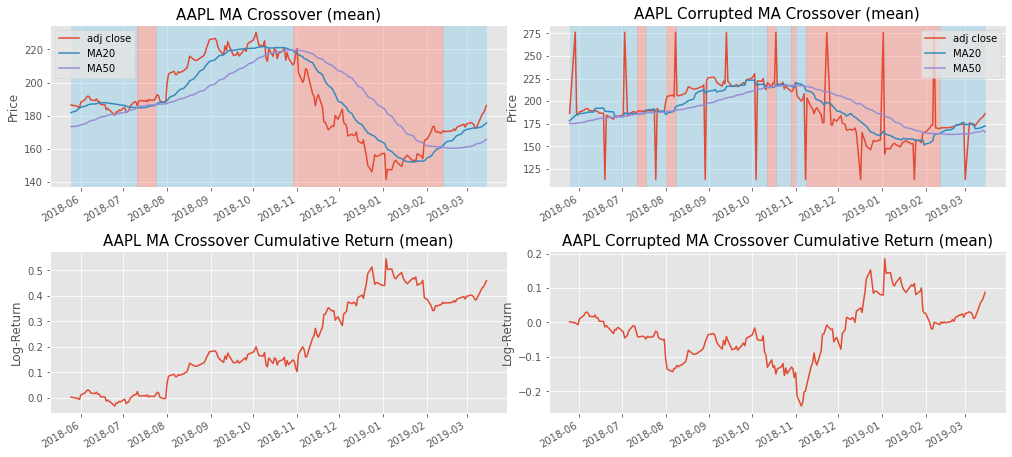

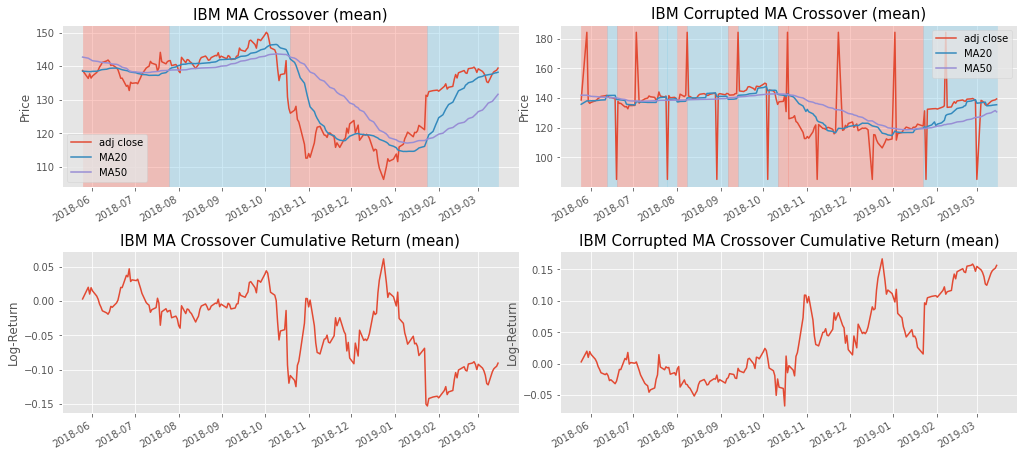

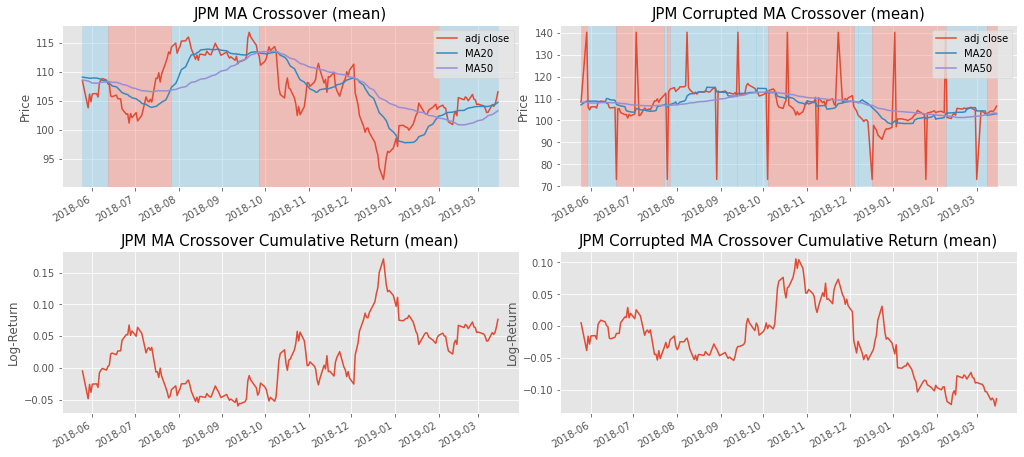

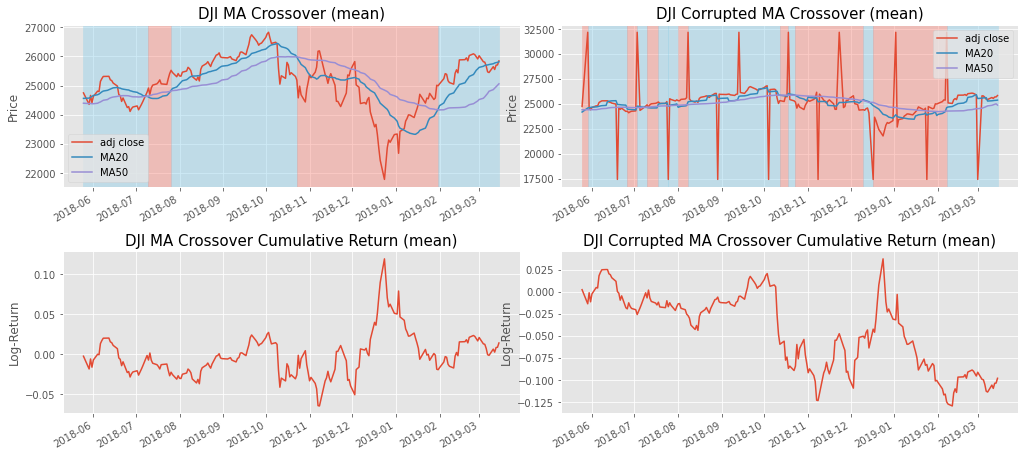

In [ ]:
for stock in adj_closes.columns:
    fig, axes = plt.subplots(2,2, figsize=(14,7))
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.4)
    
    # Moving Average Crossover
    adj_close = adj_closes[stock]

    ma20 = adj_close.rolling(20).mean().dropna()
    ma50 = adj_close.rolling(50).mean().dropna()

    ma_dif = (ma20 - ma50).dropna()
    ma_signs = np.sign(ma_dif)
    signs = ma_signs.copy()
    idx = ma_signs.index[0]

    # crossover plot 
    ax = axes[0,0]
    adj_close[idx:].plot(ax=ax, label='adj close')
    ma20[idx:].plot(ax=ax, label='MA20')
    ma50.plot(ax=ax, label='MA50')
    decisions = get_decisions(ma_signs)
    for dec in decisions:
        ax.axvspan(dec['start'], dec['end'], alpha=0.4, color = 'skyblue' if dec['val'] == 1 else 'salmon')
    ax.legend()
    ax.set_title(stock+" MA Crossover (mean)", fontsize=15)
    ax.set_ylabel('Price', fontsize=12)
    ax.set_xlabel('')

    # cumulative returns
    returns = np.log(adj_close).diff()[idx:]
    returns = returns * ma_signs
    ax = axes[1,0]
    returns.cumsum().plot(ax=ax)
    ax.set_title(stock+" MA Crossover Cumulative Return (mean)", fontsize=15)
    ax.set_ylabel('Log-Return', fontsize=12)
    ax.set_xlabel('')


    

    # Moving Average Crossover with outliers
    adj_close = corrupted_adj_closes[stock]

    ma20 = adj_close.rolling(20).mean().dropna()
    ma50 = adj_close.rolling(50).mean().dropna()

    ma_dif = (ma20 - ma50).dropna()
    ma_signs = np.sign(ma_dif)
    signs_corrupted = ma_signs.copy()
    idx = ma_signs.index[0]

    # crossover plot 
    ax = axes[0,1]
    adj_close[idx:].plot(ax=ax, label='adj close')
    ma20[idx:].plot(ax=ax, label='MA20')
    ma50.plot(ax=ax, label='MA50')

    decisions = get_decisions(ma_signs)
    for dec in decisions:
        ax.axvspan(dec['start'], dec['end'], alpha=0.4, color = 'skyblue' if dec['val'] == 1 else 'salmon')

    ax.legend()
    ax.set_title(stock+" Corrupted MA Crossover (mean)", fontsize=15)
    ax.set_ylabel('Price', fontsize=12)
    ax.set_xlabel('')


    # cumulative returns
    returns = np.log(adj_closes[stock]).diff()[idx:]
    returns = returns * ma_signs
    ax = axes[1,1]
    returns.cumsum().plot(ax=ax)
    ax.set_title(stock+" Corrupted MA Crossover Cumulative Return (mean)", fontsize=15)
    ax.set_ylabel('Log-Return', fontsize=12)
    ax.set_xlabel('')

    print('Region overlap {}:\t{:.1%}'.format(stock, (signs == signs_corrupted).sum()/len(signs)))
    fig.savefig('Rolling_Mean_Moving_Average_Crossover_Strategy_'+stock+'.eps', dpi=200, bbox_inches='tight') 

We observe that the percentage of crossover, and hence the buy and sell decisions, are largely impacted by the presence of outliers which leads to significant differences in perfromance. This suggests the sensibility of rolling means to outliers and the need for a more robust strategy.

### 4.4.2 Robust Moving Average Crossover

We repeat the strategy studied in section 4.4.1, this time using the \textbf{rolling median} instead of the rolling mean in order to compare the methods and show the results in Figure \ref{4.4.2} as well as the percentage of crossover regions in Table \ref{tab:4.4.2}.

Region overlap AAPL:	98.5%


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

Region overlap IBM:	98.0%


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

Region overlap JPM:	96.5%


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

Region overlap DJI:	98.5%


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

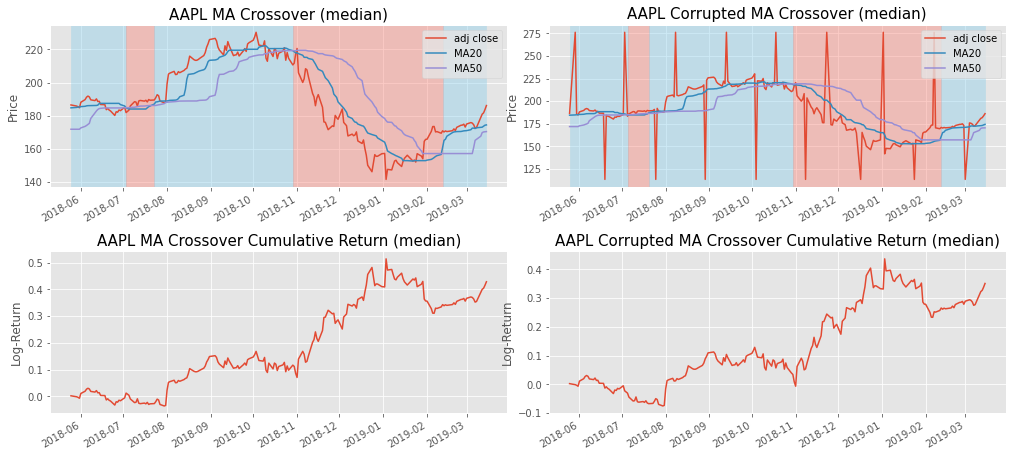

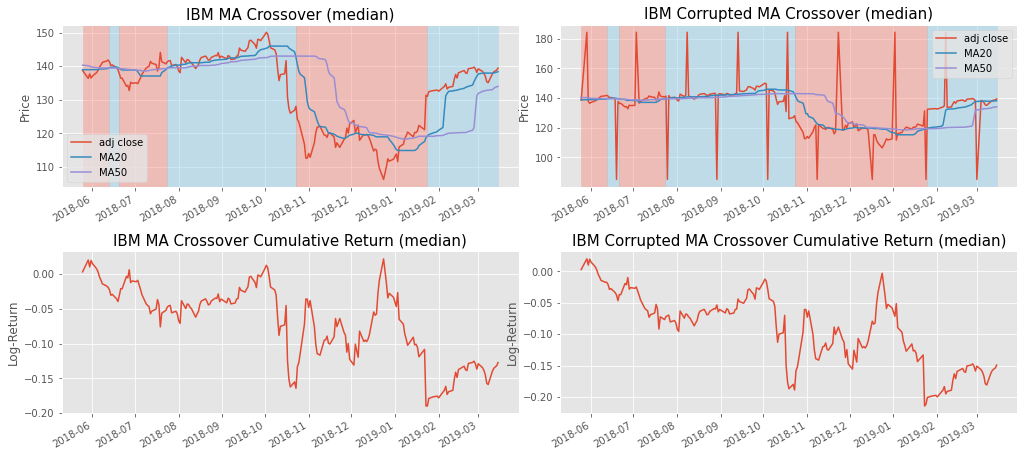

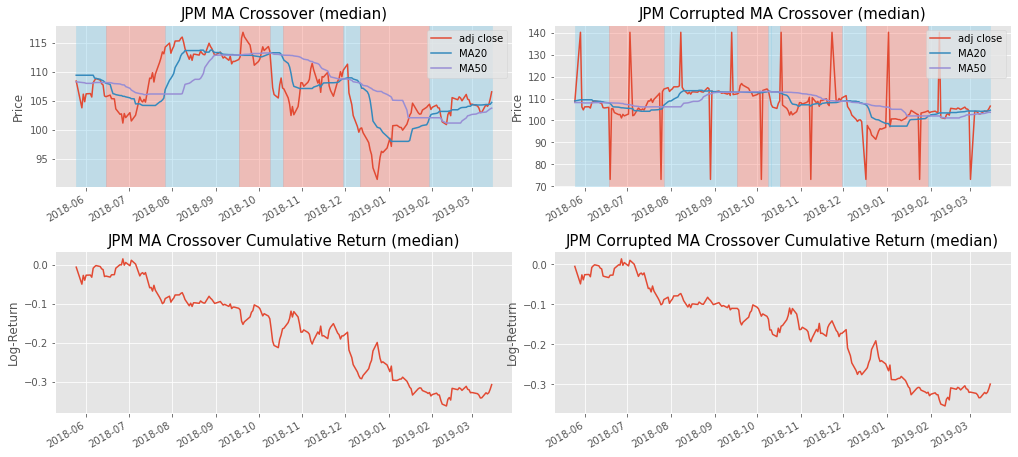

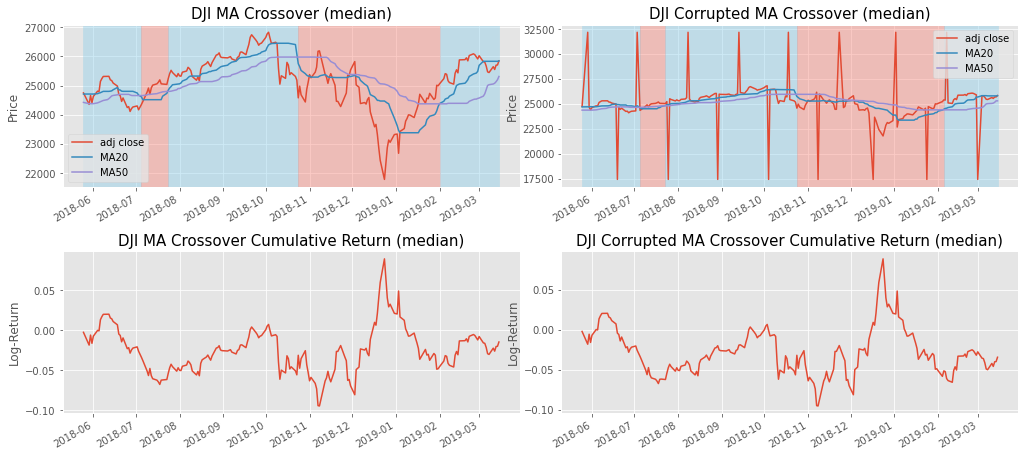

In [ ]:
for stock in adj_closes.columns:
    fig, axes = plt.subplots(2,2, figsize=(14,7))
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.4)
    
    # Moving Average Crossover (median) 
    adj_close = adj_closes[stock]

    ma20 = adj_close.rolling(20).median().dropna()
    ma50 = adj_close.rolling(50).median().dropna()

    ma_dif = (ma20 - ma50).dropna()
    ma_signs = np.sign(ma_dif)
    signs = ma_signs.copy()
    idx = ma_signs.index[0]

    # crossover plot 
    ax = axes[0,0]
    adj_close[idx:].plot(ax=ax, label='adj close')
    ma20[idx:].plot(ax=ax, label='MA20')
    ma50.plot(ax=ax, label='MA50')
    decisions = get_decisions(ma_signs)
    for dec in decisions:
        ax.axvspan(dec['start'], dec['end'], alpha=0.4, color = 'skyblue' if dec['val'] == 1 else 'salmon')
    ax.legend()
    ax.set_title(stock+" MA Crossover (median)", fontsize=15)
    ax.set_ylabel('Price', fontsize=12)
    ax.set_xlabel('')

    # cumulative returns
    returns = np.log(adj_close).diff()[idx:]
    returns = returns * ma_signs
    ax = axes[1,0]
    returns.cumsum().plot(ax=ax)
    ax.set_title(stock+" MA Crossover Cumulative Return (median)", fontsize=15)
    ax.set_ylabel('Log-Return', fontsize=12)
    ax.set_xlabel('')
 
    # Moving Average Crossover with outliers (median) 
    adj_close = corrupted_adj_closes[stock]

    ma20 = adj_close.rolling(20).median().dropna()
    ma50 = adj_close.rolling(50).median().dropna()

    ma_dif = (ma20 - ma50).dropna()
    ma_signs = np.sign(ma_dif)
    signs_corrupted = ma_signs.copy()
    idx = ma_signs.index[0]

    # crossover plot 
    ax = axes[0,1]
    adj_close[idx:].plot(ax=ax, label='adj close')
    ma20[idx:].plot(ax=ax, label='MA20')
    ma50.plot(ax=ax, label='MA50')
    decisions = get_decisions(ma_signs)
    for dec in decisions:
        ax.axvspan(dec['start'], dec['end'], alpha=0.4, color = 'skyblue' if dec['val'] == 1 else 'salmon')
    ax.legend()
    ax.set_title(stock+" Corrupted MA Crossover (median)", fontsize=15)
    ax.set_ylabel('Price', fontsize=12)
    ax.set_xlabel('')


    # cumulative returns
    returns = np.log(adj_closes[stock]).diff()[idx:]
    returns = returns * ma_signs
    ax = axes[1,1]
    returns.cumsum().plot(ax=ax)
    ax.set_title(stock+" Corrupted MA Crossover Cumulative Return (median)", fontsize=15)
    ax.set_ylabel('Log-Return', fontsize=12)
    ax.set_xlabel('')

    print('Region overlap {}:\t{:.1%}'.format(stock, (signs == signs_corrupted).sum()/len(signs)))
    fig.savefig('Rolling_Median_Moving_Average_Crossover_Strategy_'+stock+'.eps', dpi=200, bbox_inches='tight')

We observe from Table \ref{tab:4.4.2} and from the highlighting of the plots in Figure \ref{4.4.2} that the rolling median has much more overlapping when adding the outlier points which suggests it is a much more robust method to contaminated data than the mean method. The buy and sell decisions, and consequently the cumulative returns, are almost identical when adding the outliers than when not. There, in accordance with our previous observations and conclusions, we define that using the mean to estimate the average of a signal in presence of outliers is not appropriate. Instead, the median estimator is a more robust solution to outliers and is defined to be a better choice in defining corrupted signals.